In [37]:
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.colors as colors
from mpl_toolkits.axes_grid1 import make_axes_locatable
import seaborn as sns

from pylab import rcParams
rcParams['figure.figsize'] = 5, 5

from pandas import set_option
# set_option("display.max_rows", 10)
pd.options.mode.chained_assignment = None

###### Import packages needed for the make_vars functions
from scipy.interpolate import interp1d
import pywt

from skimage.filters.rank import entropy
from skimage.morphology import rectangle
from skimage.util import img_as_ubyte

##### import stuff from scikit learn
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import KFold, cross_val_score, LeaveOneGroupOut, GridSearchCV

filename = 'data/facies_vectors.csv'
training_data = pd.read_csv(filename)
training_data.head()

,Facies,Formation,Well Name,Depth,GR,ILD_log10,DeltaPHI,PHIND,PE,NM_M,RELPOS
0,3,A1 SH,SHRIMPLIN,2793.0,77.45,0.664,9.9,11.915,4.6,1,1.000
1,3,A1 SH,SHRIMPLIN,2793.5,78.26,0.661,14.2,12.565,4.1,1,0.979
2,3,A1 SH,SHRIMPLIN,2794.0,79.05,0.658,14.8,13.050,3.6,1,0.957
3,3,A1 SH,SHRIMPLIN,2794.5,86.10,0.655,13.9,13.115,3.5,1,0.936
4,3,A1 SH,SHRIMPLIN,2795.0,74.58,0.647,13.5,13.300,3.4,1,0.915


In [2]:
training_data.describe()

,Facies,Depth,GR,ILD_log10,DeltaPHI,PHIND,PE,NM_M,RELPOS
count,4149.000000,4149.000000,4149.000000,4149.000000,4149.000000,4149.000000,3232.000000,4149.000000,4149.000000
mean,4.503254,2906.867438,64.933985,0.659566,4.402484,13.201066,3.725014,1.518438,0.521852
std,2.474324,133.300164,30.302530,0.252703,5.274947,7.132846,0.896152,0.499720,0.286644
min,1.000000,2573.500000,10.149000,-0.025949,-21.832000,0.550000,0.200000,1.000000,0.000000
25%,2.000000,2821.500000,44.730000,0.498000,1.600000,8.500000,3.100000,1.000000,0.277000
50%,4.000000,2932.500000,64.990000,0.639000,4.300000,12.020000,3.551500,2.000000,0.528000
75%,6.000000,3007.000000,79.438000,0.822000,7.500000,16.050000,4.300000,2.000000,0.769000
max,9.000000,3138.000000,361.150000,1.800000,19.312000,84.400000,8.094000,2.000000,1.000000


## Creating variable-making functions

In [3]:
def make_dwt_vars_cD(wells_df,logs,levels,wavelet):

    wave= pywt.Wavelet(wavelet)
    max_level = max(levels)
    
    grouped = wells_df.groupby(['Well Name'])
    new_df = pd.DataFrame()
    for key in grouped.groups.keys():
    
        depth = grouped.get_group(key)['Depth']
        temp_df = pd.DataFrame()
        temp_df['Depth'] = depth
        for log in logs:
      
            temp_data = grouped.get_group(key)[log]

            cA_4, cD_4, cD_3, cD_2, cD_1 = pywt.wavedec(temp_data,wave,level=4,mode='symmetric')
            dict_cD_levels = {1:cD_1, 2:cD_2, 3:cD_3, 4:cD_4}
            #new_depth = np.linspace(min(depth),max(depth),len(cD))
            #fD = interp1d(new_depth,cD,kind='nearest')
                
            for i in levels:
                new_depth = np.linspace(min(depth),max(depth),len(dict_cD_levels[i]))
                fA = interp1d(new_depth,dict_cD_levels[i],kind='nearest')
                #temp_df[log + '_cD_step_level_' + str(i)] = fD(depth)
                temp_df[log + '_cD_level_' + str(i)] = fA(depth)
    
        temp_df['Well Name'] = [key for _ in range(len(depth))]
        new_df = new_df.append(temp_df)
        
    new_df = new_df.sort_index()
    new_df = new_df.drop(['Well Name','Depth'],axis=1)
    wells_df = wells_df[['Facies', 'Formation', 'Well Name', 'Depth']]
    return pd.concat([wells_df, new_df],axis=1)

In [4]:
def make_dwt_vars_cA(wells_df,logs,levels,wavelet):

    wave= pywt.Wavelet(wavelet)
    max_level = max(levels)
    
    grouped = wells_df.groupby(['Well Name'])
    new_df = pd.DataFrame()
    for key in grouped.groups.keys():
    
        depth = grouped.get_group(key)['Depth']
        temp_df = pd.DataFrame()
        temp_df['Depth'] = depth
        for log in logs:
      
            temp_data = grouped.get_group(key)[log]
              
            for i in levels:
                
                    cA_cD = pywt.wavedec(temp_data,wave,level=i,mode='symmetric')
                    cA = cA_cD[0]
                    new_depth = np.linspace(min(depth),max(depth),len(cA))
                    fA = interp1d(new_depth,cA,kind='nearest')
                    #temp_df[log + '_cD_step_level_' + str(i)] = fD(depth)
                    temp_df[log + '_cA_level_' + str(i)] = fA(depth)
    
        temp_df['Well Name'] = [key for _ in range(len(depth))]
        new_df = new_df.append(temp_df)
        
    new_df = new_df.sort_index()
    new_df = new_df.drop(['Well Name','Depth'],axis=1)
    wells_df = wells_df[['Facies', 'Formation', 'Well Name', 'Depth']]
    return pd.concat([wells_df, new_df],axis=1)

In [5]:
def make_entropy_vars(wells_df,logs,l_foots):
    
    new_df = pd.DataFrame()
    grouped = wells_df.groupby(['Well Name'])
    
    for key in grouped.groups.keys():
    
        depth = grouped.get_group(key)['Depth']
        temp_df = pd.DataFrame()
        temp_df['Depth'] = depth
        
        for log in logs:
            temp_data = grouped.get_group(key)[log]
            image = np.vstack((temp_data,temp_data,temp_data))
            image -= np.median(image) 
            image /= np.max(np.abs(image))
            image = img_as_ubyte(image)
            
            for l_foot in l_foots:     
                footprint = rectangle(l_foot,3)
                temp_df[log + '_entropy_foot' + str(l_foot)] = entropy(image,footprint)[0,:]
    
        temp_df['Well Name'] = [key for _ in range(len(depth))]
        new_df = new_df.append(temp_df)
    
    new_df = new_df.sort_index()
    new_df = new_df.drop(['Well Name','Depth'],axis=1)
    wells_df = wells_df[['Facies', 'Formation', 'Well Name', 'Depth']]
    return pd.concat([wells_df,new_df],axis=1)

In [6]:
def make_gradient_vars(wells_df,logs,dx_list):
    
    new_df = pd.DataFrame()
    grouped = wells_df.groupby(['Well Name'])
    
    for key in grouped.groups.keys():
    
        depth = grouped.get_group(key)['Depth']
        temp_df = pd.DataFrame()
        temp_df['Depth'] = depth

        for log in logs:

            temp_data = grouped.get_group(key)[log]

            for dx in dx_list:

                temp_df[log + 'gradient_dx' + str(dx)] = np.gradient(temp_data,dx)

        temp_df['Well Name'] = [key for _ in range(len(depth))]
        new_df = new_df.append(temp_df) 
    
    new_df = new_df.sort_index()
    new_df = new_df.drop(['Well Name','Depth'],axis=1)
    wells_df = wells_df[['Facies', 'Formation', 'Well Name', 'Depth']]
    return pd.concat([wells_df,new_df],axis=1)

In [7]:
def make_moving_av_vars(wells_df,logs,windows):
    
    new_df = pd.DataFrame()
    grouped = wells_df.groupby(['Well Name'])

    for key in grouped.groups.keys():

        temp_df = pd.DataFrame()
        temp_df['Depth'] = grouped.get_group(key)['Depth']
        
        for log in logs:

            temp_data = grouped.get_group(key)[log]
            
            for window in windows:
                temp_df[log + '_moving_av_' + str(window) + 'ft'] = pd.rolling_mean(arg=temp_data, window=window, min_periods=1, center=True)                
                
        temp_df['Well Name'] = [key for _ in range(len(temp_df['Depth']))]
        new_df = new_df.append(temp_df) 

        
    new_df = new_df.sort_index()
    new_df = new_df.drop(['Well Name','Depth'],axis=1)
    wells_df = wells_df[['Facies', 'Formation', 'Well Name', 'Depth']]
    return pd.concat([wells_df,new_df],axis=1)

In [8]:
def make_moving_std_vars(wells_df,logs,windows):
    new_df = pd.DataFrame()
    grouped = wells_df.groupby(['Well Name'])

    for key in grouped.groups.keys():
        temp_df = pd.DataFrame()
        temp_df['Depth'] = grouped.get_group(key)['Depth']
        
        for log in logs:

            temp_data = grouped.get_group(key)[log]
            
            for window in windows:
                temp_df[log + '_moving_std_' + str(window) + 'ft'] = pd.rolling_std(arg=temp_data, window=window, min_periods=1, center=True)                
                
        temp_df['Well Name'] = [key for _ in range(len(temp_df['Depth']))]
        new_df = new_df.append(temp_df) 

        
    new_df = new_df.sort_index()
    new_df = new_df.drop(['Well Name','Depth'],axis=1)
    wells_df = wells_df[['Facies', 'Formation', 'Well Name', 'Depth']]
    return pd.concat([wells_df,new_df],axis=1)

In [9]:
def make_moving_max_vars(wells_df,logs,windows):
    new_df = pd.DataFrame()
    grouped = wells_df.groupby(['Well Name'])

    for key in grouped.groups.keys():
        temp_df = pd.DataFrame()
        temp_df['Depth'] = grouped.get_group(key)['Depth']
        
        for log in logs:

            temp_data = grouped.get_group(key)[log]
            
            for window in windows:
                temp_df[log + '_moving_max_' + str(window) + 'ft'] = pd.rolling_max(arg=temp_data, window=window, min_periods=1, center=True)                
                
        temp_df['Well Name'] = [key for _ in range(len(temp_df['Depth']))]
        new_df = new_df.append(temp_df) 

        
    new_df = new_df.sort_index()
    new_df = new_df.drop(['Well Name','Depth'],axis=1)
    wells_df = wells_df[['Facies', 'Formation', 'Well Name', 'Depth']]
    return pd.concat([wells_df,new_df],axis=1)

In [10]:
def make_moving_min_vars(wells_df,logs,windows):
    new_df = pd.DataFrame()
    grouped = wells_df.groupby(['Well Name'])

    for key in grouped.groups.keys():
        temp_df = pd.DataFrame()
        temp_df['Depth'] = grouped.get_group(key)['Depth']
        
        for log in logs:

            temp_data = grouped.get_group(key)[log]
            
            for window in windows:
                temp_df[log + '_moving_min_' + str(window) + 'ft'] = pd.rolling_min(arg=temp_data, window=window, min_periods=1, center=True)                
                
        temp_df['Well Name'] = [key for _ in range(len(temp_df['Depth']))]
        new_df = new_df.append(temp_df) 

        
    new_df = new_df.sort_index()
    new_df = new_df.drop(['Well Name','Depth'],axis=1)
    wells_df = wells_df[['Facies', 'Formation', 'Well Name', 'Depth']]
    return pd.concat([wells_df,new_df],axis=1)

In [11]:
##### cD From wavelet db1
dwt_db1_cD_df = make_dwt_vars_cD(wells_df=training_data, logs=['GR', 'ILD_log10', 'DeltaPHI', 'PE', 'PHIND'],
                       levels=[1, 2, 3, 4], wavelet='db1')

##### cA From wavelet db1
dwt_db1_cA_df = make_dwt_vars_cA(wells_df=training_data, logs=['GR', 'ILD_log10', 'DeltaPHI', 'PE', 'PHIND'],
                       levels=[1, 2, 3, 4], wavelet='db1')

##### cD From wavelet db3
dwt_db3_cD_df = make_dwt_vars_cD(wells_df=training_data, logs=['GR', 'ILD_log10', 'DeltaPHI', 'PE', 'PHIND'],
                       levels=[1, 2, 3, 4], wavelet='db3')

##### cA From wavelet db3
dwt_db3_cA_df = make_dwt_vars_cA(wells_df=training_data, logs=['GR', 'ILD_log10', 'DeltaPHI', 'PE', 'PHIND'],
                       levels=[1, 2, 3, 4], wavelet='db3')

##### From entropy
entropy_df = make_entropy_vars(wells_df=training_data, logs=['GR', 'ILD_log10', 'DeltaPHI', 'PE', 'PHIND'],
                               l_foots=[2, 3, 4, 5, 7, 10])

###### From gradient
gradient_df = make_gradient_vars(wells_df=training_data, logs=['GR', 'ILD_log10', 'DeltaPHI', 'PE', 'PHIND'],
                                 dx_list=[2, 3, 4, 5, 6, 10, 20])

##### From moving average
moving_av_df = make_moving_av_vars(wells_df=training_data, logs=['GR', 'ILD_log10', 'DeltaPHI', 'PE', 'PHIND'],
                                   windows=[1, 2, 5, 10, 20])

##### From moving standard deviation
moving_std_df = make_moving_std_vars(wells_df=training_data, logs=['GR', 'ILD_log10', 'DeltaPHI', 'PE', 'PHIND'],
                                     windows=[3 , 4, 5, 7, 10, 15, 20])

##### From moving max
moving_max_df = make_moving_max_vars(wells_df=training_data, logs=['GR', 'ILD_log10', 'DeltaPHI', 'PE', 'PHIND'],
                                     windows=[3, 4, 5, 7, 10, 15, 20])

##### From moving min
moving_min_df = make_moving_min_vars(wells_df=training_data, logs=['GR', 'ILD_log10', 'DeltaPHI', 'PE', 'PHIND'],
                                     windows=[3 , 4, 5, 7, 10, 15, 20])

In [12]:
list_df_var = [dwt_db1_cD_df, dwt_db1_cA_df, dwt_db3_cD_df, dwt_db3_cA_df,
               entropy_df, gradient_df, moving_av_df, moving_std_df, moving_max_df, moving_min_df]
combined_df = training_data
for var_df in list_df_var:
    temp_df = var_df
    temp_df = temp_df.drop(['Facies', 'Formation', 'Well Name', 'Depth'], axis=1)
    combined_df = pd.concat([combined_df,temp_df],axis=1)
combined_df.dropna(inplace=True)
print (combined_df.shape)
combined_df.head(5)

(3204, 286)


,Facies,Formation,Well Name,Depth,GR,ILD_log10,DeltaPHI,PHIND,PE,NM_M,...,PE_moving_min_10ft,PE_moving_min_15ft,PE_moving_min_20ft,PHIND_moving_min_3ft,PHIND_moving_min_4ft,PHIND_moving_min_5ft,PHIND_moving_min_7ft,PHIND_moving_min_10ft,PHIND_moving_min_15ft,PHIND_moving_min_20ft
0,3,A1 SH,SHRIMPLIN,2793.0,77.45,0.664,9.9,11.915,4.6,1,...,3.4,3.4,3.4,11.915,11.915,11.915,11.915,11.915,11.915,11.915
1,3,A1 SH,SHRIMPLIN,2793.5,78.26,0.661,14.2,12.565,4.1,1,...,3.4,3.4,3.4,11.915,11.915,11.915,11.915,11.915,11.915,11.915
2,3,A1 SH,SHRIMPLIN,2794.0,79.05,0.658,14.8,13.050,3.6,1,...,3.4,3.4,3.4,12.565,11.915,11.915,11.915,11.915,11.915,11.915
3,3,A1 SH,SHRIMPLIN,2794.5,86.10,0.655,13.9,13.115,3.5,1,...,3.4,3.4,3.4,13.050,12.565,12.565,11.915,11.915,11.915,11.915
4,3,A1 SH,SHRIMPLIN,2795.0,74.58,0.647,13.5,13.300,3.4,1,...,3.4,3.4,3.4,13.115,13.050,13.050,12.565,11.915,11.915,11.915


In [13]:
###### create predictor and target arrays
X = combined_df.iloc[:, 4:]
y = combined_df['Facies']
groups = combined_df['Well Name']

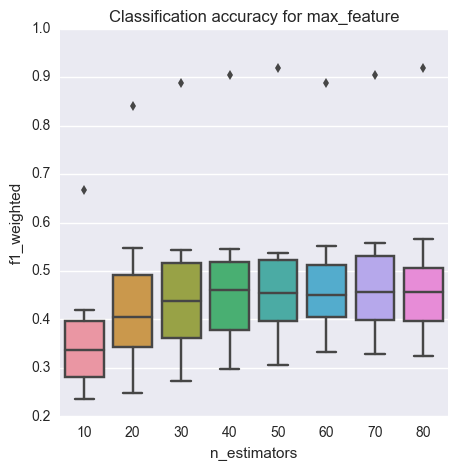

In [23]:
################ Testing accuracy with variable n_estimators 
#rang = np.arange(10, 81, 10)
rang = np.arange(10, 81, 10)
scores = []

for val in rang:
    Cl = GradientBoostingClassifier(loss='deviance', learning_rate=0.003, n_estimators=val,
                                    max_features = 'sqrt', subsample = 0.8)
    cv=LeaveOneGroupOut().split(X, y, groups)
    validated = cross_val_score(Cl, X, y, scoring='f1_weighted', cv=cv)
    scores.append(validated)
    
scores = np.array(scores)
scores = np.swapaxes(scores, 0, 1)
scores = pd.DataFrame(data=scores, columns=rang)
    
sns.boxplot(data=scores)

plt.xlabel('n_estimators')
plt.ylabel('f1_weighted')
plt.title('Classification accuracy for max_feature')
plt.show()

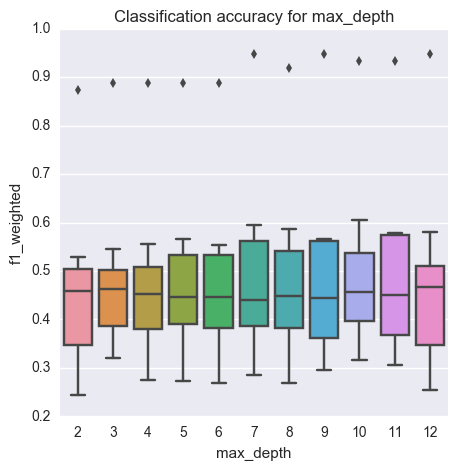

In [29]:
################ Tuning max_depth
#rang = np.arange(10, 81, 10)
rang = np.arange(2, 13, 1)
scores = []

for val in rang:
    Cl = GradientBoostingClassifier(loss='deviance', learning_rate=0.003, n_estimators=40, max_depth=val,
                                    max_features = 'sqrt', subsample = 0.8)
    cv=LeaveOneGroupOut().split(X, y, groups)
    validated = cross_val_score(Cl, X, y, scoring='f1_weighted', cv=cv, n_jobs=-1)
    scores.append(validated)
    
scores = np.array(scores)
scores = np.swapaxes(scores, 0, 1)
scores = pd.DataFrame(data=scores, columns=rang)
    
sns.boxplot(data=scores)

plt.xlabel('max_depth')
plt.ylabel('f1_weighted')
plt.title('Classification accuracy for max_depth')
plt.show()

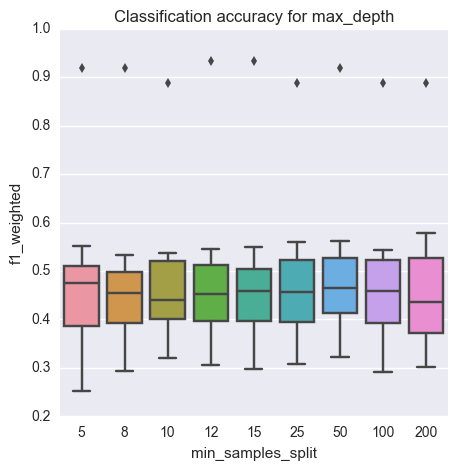

In [32]:
################ Tuning min_samples_split
#rang = np.arange(2, 41, 4)
rang = [5, 8, 10, 12, 15, 25, 50, 100, 200]
scores = []

for val in rang:
    Cl = GradientBoostingClassifier(loss='deviance', learning_rate=0.003, n_estimators=40, max_depth=4,
                                    min_samples_split=val, max_features = 'sqrt', subsample = 0.8)
    cv=LeaveOneGroupOut().split(X, y, groups)
    validated = cross_val_score(Cl, X, y, scoring='f1_weighted', cv=cv, n_jobs=-1)
    scores.append(validated)
    
scores = np.array(scores)
scores = np.swapaxes(scores, 0, 1)
scores = pd.DataFrame(data=scores, columns=rang)
    
sns.boxplot(data=scores)

plt.xlabel('min_samples_split')
plt.ylabel('f1_weighted')
plt.title('Classification accuracy for max_depth')
plt.show()

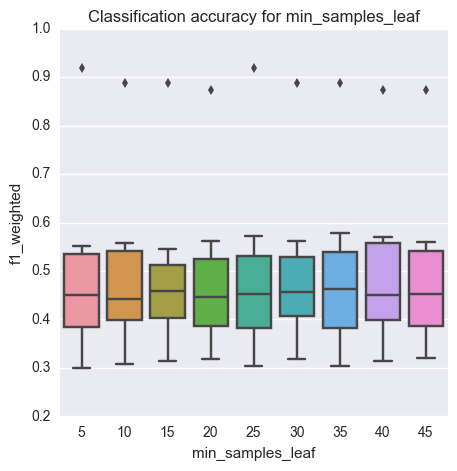

In [33]:
################ Tuning min_samples_leaf
rang = np.arange(5, 50, 5)
scores = []

for val in rang:
    Cl = GradientBoostingClassifier(loss='deviance', learning_rate=0.003, n_estimators=40, max_depth=4,
                                    min_samples_split=50, min_samples_leaf=val, max_features = 'sqrt', subsample = 0.8)
    cv=LeaveOneGroupOut().split(X, y, groups)
    validated = cross_val_score(Cl, X, y, scoring='f1_weighted', cv=cv, n_jobs=-1)
    scores.append(validated)
    
scores = np.array(scores)
scores = np.swapaxes(scores, 0, 1)
scores = pd.DataFrame(data=scores, columns=rang)
    
sns.boxplot(data=scores)

plt.xlabel('min_samples_leaf')
plt.ylabel('f1_weighted')
plt.title('Classification accuracy for min_samples_leaf')
plt.show()

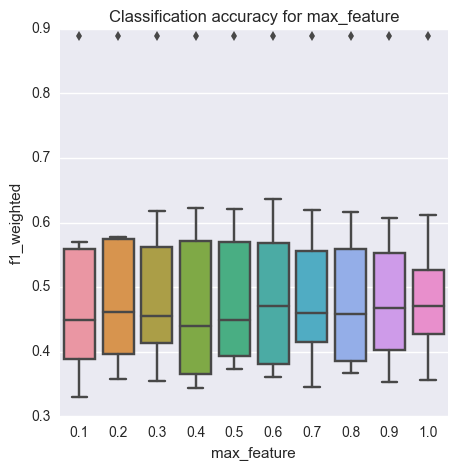

In [34]:
################ Tuning max_feature
rang = np.arange(0.1, 1.05, 0.1)
scores = []

for val in rang:
    Cl = GradientBoostingClassifier(loss='deviance', learning_rate=0.003, n_estimators=40, max_depth=4,
                                    min_samples_split=50, min_samples_leaf=35, max_features = val, subsample = 0.8)
    cv=LeaveOneGroupOut().split(X, y, groups)
    validated = cross_val_score(Cl, X, y, scoring='f1_weighted', cv=cv, n_jobs=-1)
    scores.append(validated)
    
scores = np.array(scores)
scores = np.swapaxes(scores, 0, 1)
scores = pd.DataFrame(data=scores, columns=rang)
    
sns.boxplot(data=scores)

plt.xlabel('max_feature')
plt.ylabel('f1_weighted')
plt.title('Classification accuracy for max_feature')
plt.show()

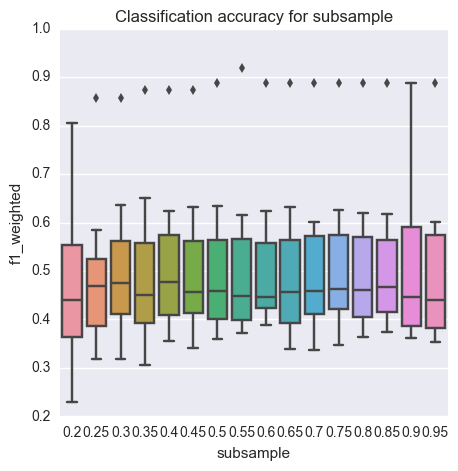

In [35]:
################ Tuning subsample
rang = np.arange(0.2, 1.0, 0.05)
#rang = [2, 5, 10, 15, 25]
scores = []

for val in rang:
    Cl = GradientBoostingClassifier(loss='deviance', learning_rate=0.003, n_estimators=40, max_depth=4,
                                    min_samples_split=50, min_samples_leaf=35, max_features = 0.6, subsample = val)
    cv=LeaveOneGroupOut().split(X, y, groups)
    validated = cross_val_score(Cl, X, y, scoring='f1_weighted', cv=cv, n_jobs=-1)
    scores.append(validated)
    
scores = np.array(scores)
scores = np.swapaxes(scores, 0, 1)
scores = pd.DataFrame(data=scores, columns=rang)
    
sns.boxplot(data=scores)

plt.xlabel('subsample')
plt.ylabel('f1_weighted')
plt.title('Classification accuracy for subsample')
plt.show()

# Tuning hyper-parameters for f1_weighted
Best parameters set found on development set:
{'max_features': 0.6, 'subsample': 0.4, 'min_samples_split': 50, 'loss': 'deviance', 'max_depth': 4, 'n_estimators': 200, 'learning_rate': 0.01, 'min_samples_leaf': 35}
Score: 0.506



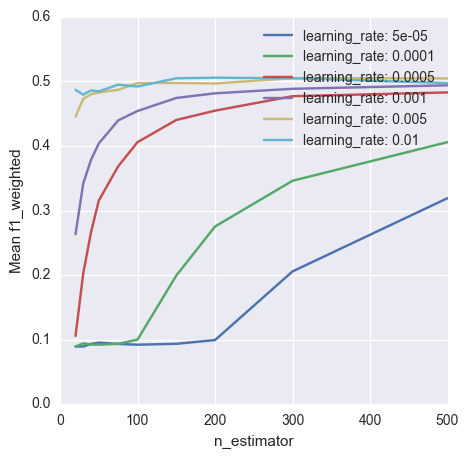

In [39]:
################ Tuning learning_rate and n_estimators

estimators_range = [20, 30, 40, 50, 75, 100, 150, 200, 300, 500]
learning_rate_range= [0.00005, 0.0001, 0.0005, 0.001, 0.005, 0.01]
param_grid = dict(loss=['deviance'], n_estimators=estimators_range, learning_rate=learning_rate_range, max_depth=[4],
                    min_samples_split = [50], min_samples_leaf = [35], max_features = [0.6], subsample = [0.4])
Cl=GradientBoostingClassifier()
cv=LeaveOneGroupOut()
# scoring options: ['accuracy', 'adjusted_rand_score', 'average_precision', 'f1', 'log_loss', 'mean_squared_error', 'precision', 'r2', 'recall', 'roc_auc'] 
scores = ['f1_weighted']
for score in scores:
    print("# Tuning hyper-parameters for %s" % score)
    print("Best parameters set found on development set:")
    grid = GridSearchCV(Cl, param_grid, cv=cv, scoring='%s' % score)
    #clf = grid.get_params()
    clf = grid.fit(X, y, groups=groups)
    print(clf.cv_results_['params'][clf.best_index_])
    print("Score: %0.03f" % clf.best_score_)
    print("")
    #for params, mean_score, scores in clf.grid_scores_:
         #print("%0.3f (+/-%0.03f) for %r" % (mean_score, scores.std() * 2, params))
    # Do a graphic representation
    scores = [x[1] for x in clf.grid_scores_]
    scores = np.array(scores).reshape(len(learning_rate_range), len(estimators_range))
    for ind, i in enumerate(learning_rate_range):
        plt.plot(estimators_range, scores[ind], label='learning_rate: ' + str(i))
    plt.legend()
    plt.xlabel('n_estimator')
    plt.ylabel('Mean ' + score)
    plt.show()

# Tuning hyper-parameters for f1_weighted
Best parameters set found on development set:
{'max_features': 0.6, 'subsample': 0.4, 'min_samples_split': 50, 'loss': 'deviance', 'max_depth': 4, 'n_estimators': 75, 'learning_rate': 0.05, 'min_samples_leaf': 35}
Score: 0.510



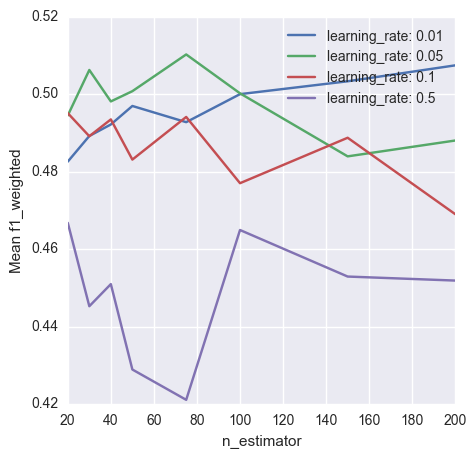

In [40]:
################ Tuning learning_rate and n_estimators

estimators_range = [20, 30, 40, 50, 75, 100, 150, 200]
learning_rate_range= [0.01, 0.05, 0.1, 0.5]
param_grid = dict(loss=['deviance'], n_estimators=estimators_range, learning_rate=learning_rate_range, max_depth=[4],
                    min_samples_split = [50], min_samples_leaf = [35], max_features = [0.6], subsample = [0.4])
Cl=GradientBoostingClassifier()
cv=LeaveOneGroupOut()
# scoring options: ['accuracy', 'adjusted_rand_score', 'average_precision', 'f1', 'log_loss', 'mean_squared_error', 'precision', 'r2', 'recall', 'roc_auc'] 
scores = ['f1_weighted']
for score in scores:
    print("# Tuning hyper-parameters for %s" % score)
    print("Best parameters set found on development set:")
    grid = GridSearchCV(Cl, param_grid, cv=cv, scoring='%s' % score)
    #clf = grid.get_params()
    clf = grid.fit(X, y, groups=groups)
    print(clf.cv_results_['params'][clf.best_index_])
    print("Score: %0.03f" % clf.best_score_)
    print("")
    #for params, mean_score, scores in clf.grid_scores_:
         #print("%0.3f (+/-%0.03f) for %r" % (mean_score, scores.std() * 2, params))
    # Do a graphic representation
    scores = [x[1] for x in clf.grid_scores_]
    scores = np.array(scores).reshape(len(learning_rate_range), len(estimators_range))
    for ind, i in enumerate(learning_rate_range):
        plt.plot(estimators_range, scores[ind], label='learning_rate: ' + str(i))
    plt.legend()
    plt.xlabel('n_estimator')
    plt.ylabel('Mean ' + score)
    plt.show()